<a href="https://colab.research.google.com/github/groda/big_data/blob/master/SparkOnSLURM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Single-Node Spark on SLURM: A Hands-On Colab Demo

**SLURM** is an acronym for **S**imple **L**inux **U**tility for **R**esource **M**anagement. The name reflects its original design goal of being a straightforward yet powerful tool for managing Linux cluster resources (see [https://github.com/groda/big_data/blob/master/SLURM.ipynb](https://github.com/groda/big_data/blob/master/SLURM.ipynb) for more details).


After setting up, configuring, and using SLURM on a single Ubuntu virtual machine (VM), this Colab demonstration walks you through running a Spark job on top of SLURM.

While running SLURM and Spark on a single node naturally hides the complexities of a true multi-node environment, it still allows you to leverage parallelism across multiple CPU cores.

Despite its simplicity, this setup provides a clear, minimal blueprint that can later be extended to real multi-node SLURM clusters and distributed Spark deployments.


>[Single-Node Spark on SLURM: A Hands-On Colab Demo](#scrollTo=ukIg5iRf3yoD)

>>[Install and launch the SLURM services](#scrollTo=R5Uy2zngnChj)

>>[Install Spark](#scrollTo=anYYDKthjvSn)

>>[Launch Spark on SLURM and execute job](#scrollTo=BGZH6AWeFvlG)



## Install and launch the SLURM services

In [ ]:
!apt install slurm-wlm -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
slurm-wlm is already the newest version (21.08.5-2ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


Configuration file.

In [ ]:
%%writefile /etc/slurm/slurm.conf
# Minimal slurm.conf for single-node testing
ClusterName=mylocalcluster
SlurmctldHost=localhost
AuthType=auth/munge
MpiDefault=none
ProctrackType=proctrack/linuxproc
ReturnToService=2
SlurmctldPidFile=/var/run/slurmctld.pid
SlurmctldPort=6817
SlurmdPidFile=/var/run/slurmd.pid
SlurmdPort=6818
StateSaveLocation=/var/spool/slurmctld
SlurmdSpoolDir=/var/spool/slurmd
SlurmUser=slurm
SlurmdLogFile=/var/log/slurmd.log
SlurmctldLogFile=/var/log/slurmctld.log
# Node and partition configuration
NodeName=localhost CPUs=2 RealMemory=7923 State=UNKNOWN
PartitionName=LocalQ Nodes=localhost Default=YES MaxTime=INFINITE State=UP

Overwriting /etc/slurm/slurm.conf


Munge key

In [ ]:
%%bash
sudo dd if=/dev/urandom of=/etc/munge/munge.key bs=1 count=1024 >/dev/null 2>&1
sudo chown munge:munge /etc/munge/munge.key
sudo chmod 400 /etc/munge/munge.key


Spool Directories

In [ ]:
%%bash
sudo mkdir -p /var/spool/slurmctld /var/spool/slurmd /var/lib/munge
sudo chown slurm:slurm /var/spool/slurm{ctld,d} /var/lib/munge
sudo chown munge:munge /var/lib/munge
sudo chmod 755 /var/spool/slurm* /var/lib/munge

Start the Services

In [ ]:
%%bash
sudo service munge stop
sudo service slurmctld stop
sudo service slurmd stop

 * Stopping MUNGE munged
   ...done.
 * Stopping slurm central management daemon slurmctld
   ...done.
 * Stopping slurm compute node daemon slurmd
   ...done.
slurmd is stopped


In [ ]:
%%bash
sudo service munge start
sudo service slurmctld start
sudo service slurmd start

 * Starting MUNGE munged
   ...done.
 * Starting slurm central management daemon slurmctld
   ...done.
 * Starting slurm compute node daemon slurmd
   ...done.


Verify Cluster Status

In [ ]:
!sinfo

PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
LocalQ*      up   infinite      1    unk localhost


If the node is not idle, set it:

In [ ]:
!sudo scontrol update NodeName=6d91971d1d4a State=IDLE

slurm_update error: Invalid node state specified


## Install Spark

In [ ]:
%%bash
wget --no-clobber https://downloads.apache.org/spark/spark-3.5.7/spark-3.5.7-bin-hadoop3.tgz
tar xzf spark-3.5.7-bin-hadoop3.tgz
mv spark-3.5.7-bin-hadoop3 ~/spark

File ‘spark-3.5.7-bin-hadoop3.tgz’ already there; not retrieving.



Set `SPARK_HOME`

In [ ]:
import os
os.environ["SPARK_HOME"] = os.environ["HOME"] + "/spark"
os.environ["PATH"] = os.environ["SPARK_HOME"] + ":" + os.environ["PATH"]

In [ ]:
%%bash
echo $SPARK_HOME

/root/spark


## Launch Spark on SLURM and execute job

The script `spark_local.slurm`
- launches a Spark cluster consisting of one master and two workers on SLURM
- executes a Spark job (`org.apache.spark.examples.SparkPi` from the examples suite) on the cluster
- when the job finishes, the Spark cluster is shut down

In [ ]:
%%writefile spark_local.slurm
#!/bin/bash
#SBATCH --job-name=spark-local
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=2
#SBATCH --time=00:05:00
#SBATCH --output=spark_%j.out

# Point to your Spark install
SPARK_HOME=$HOME/spark

# Basic Spark env (optional tuning)
export SPARK_WORKER_CORES=1
export SPARK_WORKER_MEMORY=1G

HOSTNAME=$(hostname)
MASTER_URL="spark://$HOSTNAME:7077"

echo "Starting Spark master and 2 workers on $HOSTNAME"
echo "Master URL: $MASTER_URL"

# Start master
$SPARK_HOME/sbin/start-master.sh --host $HOSTNAME &
sleep 5

# Start 2 workers (each uses 1 core)
$SPARK_HOME/sbin/start-worker.sh $MASTER_URL &
$SPARK_HOME/sbin/start-worker.sh $MASTER_URL &
sleep 5

# Submit example job
$SPARK_HOME/bin/spark-submit \
  --master $MASTER_URL \
  --class org.apache.spark.examples.SparkPi \
  $SPARK_HOME/examples/jars/spark-examples_*.jar 100

# Stop Spark
$SPARK_HOME/sbin/stop-worker.sh
$SPARK_HOME/sbin/stop-master.sh


Overwriting spark_local.slurm


And here you will have to wait a little because with the option `--wait` the `sbatch` command only returns when the job is finished (and, since this is a Spark job, even if it is little there will be a little overhead for the setup plus the time needed for the actual computation).

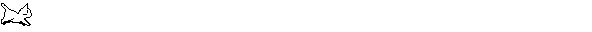

In [ ]:
%%bash
JOB_ID=$(sbatch --wait spark_local.slurm | awk '{print $NF}')
JOB_EXIT_CODE=$?
if [ "$JOB_EXIT_CODE" -eq 0 ]; then
  echo "✅ Slurm job $JOB_ID finished successfully."
else
  echo "❌ Slurm job $JOB_ID failed with exit code $JOB_EXIT_CODE."
fi

✅ Slurm job 3 finished successfully.


In [ ]:
!head spark_1.out

Starting Spark master and 2 workers on 321d8da1ee60
Master URL: spark://321d8da1ee60:7077
starting org.apache.spark.deploy.master.Master, logging to /root/spark/logs/spark--org.apache.spark.deploy.master.Master-1-321d8da1ee60.out
starting org.apache.spark.deploy.worker.Worker, logging to /root/spark/logs/spark--org.apache.spark.deploy.worker.Worker-1-321d8da1ee60.out
starting org.apache.spark.deploy.worker.Worker, logging to /root/spark/logs/spark--org.apache.spark.deploy.worker.Worker-1-321d8da1ee60.out
26/01/09 11:59:15 INFO SparkContext: Running Spark version 3.5.7
26/01/09 11:59:15 INFO SparkContext: OS info Linux, 6.6.105+, amd64
26/01/09 11:59:15 INFO SparkContext: Java version 17.0.17
26/01/09 11:59:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/09 11:59:15 INFO ResourceUtils: ==============================================================


In [ ]:
! grep "^Pi" spark_1.out

Pi is roughly 3.1414051141405115


In [ ]:
%%writefile spark_local2.sh
#!/bin/bash
#SBATCH --job-name=spark-local
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=2
#SBATCH --time=00:05:00
#SBATCH --output=spark_%j.out

# Point to your Spark install
SPARK_HOME=$HOME/spark

# Basic Spark env (optional tuning)
export SPARK_WORKER_CORES=1
export SPARK_WORKER_MEMORY=1G

HOSTNAME=$(hostname)
MASTER_URL="spark://$HOSTNAME:7077"

echo "Starting Spark master and 2 workers on $HOSTNAME"
echo "Master URL: $MASTER_URL"


MASTER_NODE=$(scontrol show hostnames $SLURM_JOB_NODELIST | head -n 1)
MASTER_URL="spark://$MASTER_NODE:7077"

# Start master
srun -N1 -w $MASTER_NODE $SPARK_HOME/sbin/start-master.sh --host $MASTER_NODE &
sleep 5

# Start 2 workers (each uses 1 core)
srun -N2 $SPARK_HOME/sbin/start-worker.sh $MASTER_URL &
sleep 5

# Submit example job
$SPARK_HOME/bin/spark-submit \
  --master $MASTER_URL \
  --class org.apache.spark.examples.SparkPi \
  $SPARK_HOME/examples/jars/spark-examples_*.jar 10

# Stop Spark
$SPARK_HOME/sbin/stop-worker.sh
$SPARK_HOME/sbin/stop-master.sh


Overwriting spark_local2.sh


In [ ]:
!sbatch spark_local2.sh

Submitted batch job 4


In [ ]:
%%bash
latest_job_id=$(ls spark_*.out | grep -oP '\d+' | sort -nr | head -n 1)
if [ -n "$latest_job_id" ]; then
  echo -e "Latest job: spark_$latest_job_id.out\n"
  cat spark_"$latest_job_id".out
else
  echo "No spark_*.out files found."
fi

Latest job: spark_3.out

Starting Spark master and 2 workers on 321d8da1ee60
Master URL: spark://321d8da1ee60:7077
starting org.apache.spark.deploy.master.Master, logging to /root/spark/logs/spark--org.apache.spark.deploy.master.Master-1-321d8da1ee60.out
starting org.apache.spark.deploy.worker.Worker, logging to /root/spark/logs/spark--org.apache.spark.deploy.worker.Worker-1-321d8da1ee60.out
starting org.apache.spark.deploy.worker.Worker, logging to /root/spark/logs/spark--org.apache.spark.deploy.worker.Worker-1-321d8da1ee60.out
26/01/09 12:22:12 INFO SparkContext: Running Spark version 3.5.7
26/01/09 12:22:12 INFO SparkContext: OS info Linux, 6.6.105+, amd64
26/01/09 12:22:12 INFO SparkContext: Java version 17.0.17
26/01/09 12:22:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/09 12:22:12 INFO ResourceUtils: ==============================================================
26/01/09 12:22:12 INFO Resourc